Lets import some of the libraries immediately required.

In [1]:
import torch
import os
import re

import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import torchvision


https://www.youtube.com/watch?v=2zptQGC-pHY&list=PLhhyoLH6IjfxkVb3Yx4mjLdwMWP5S_Hct&index=2

# Is data accessible ?

Since the dataset provided is zippped, lets unzip it first.

In [2]:
!unzip -qo ../input/dogs-vs-cats-redux-kernels-edition/test.zip
!unzip -qo ../input/dogs-vs-cats-redux-kernels-edition/train.zip

Enumerating the directory we see that it has unzipped

In [3]:
!ls

__notebook__.ipynb  test  train


# Prepping the data for the model

lets create a transform. A transform does exactly as it sounds it transforms the image to a form, in this case since we want the images to be of uniform size we resize it, then convert it into a tensor followed by normalise. The values I copied from other kernel. Its basically something you do.

In [4]:
import torchvision.transforms as transforms

my_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229,0.224,0.225],
    ),
   
])

lets look at what is actually in the train directory, the file names have their labels in the name itself. here are 5 of the files in train directory

In [5]:
os.listdir("./train")[:5]

['dog.12168.jpg',
 'cat.3425.jpg',
 'dog.7164.jpg',
 'cat.2183.jpg',
 'cat.1968.jpg']

Lets just check whether our transform works on individual images

In [6]:
img = Image.open("./train/cat.10366.jpg")
img = my_transform(img)

## The pytorch dataset and dataloader

Okay now we create the dataset class. All dataset classes are supposed to have three functions, __init__ (initialiser) , __len__ (returns length of dataset) and __getitem__ (to get individual items), basically if you implement Dataset from pytorch with these three functions, you hava a pytorch Dataset.

In [7]:
class CatsDogsDataset(Dataset):
    def __init__(self, rootdir, transform=my_transform, partial_data=None):
        self.rootdir = rootdir
        self.transform = transform
        if partial_data is not None:
            self.images = os.listdir(rootdir)[:partial_data]
        else :
            self.images = os.listdir(rootdir)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        
#         print(os.path.join(self.rootdir,self.images[index]))
        img = Image.open(os.path.join(self.rootdir,self.images[index])).convert("RGB")
        
#         image = np.array(img)
        
        if self.transform:
            img = self.transform(img)
        
        if "cat" in self.images[index]:
            label = 0
            
        elif "dog" in self.images[index]:
            label = 1
        else :
            label = -1
            
        return img, label

lets intiatiate our dataset class.

In [8]:
train_dataset = CatsDogsDataset(rootdir="./train", partial_data=5000) 
# train_dataset = CatsDogsDataset(rootdir="./train")

In [9]:
train_dataset.__len__()

5000

is it working?

In [10]:
x, y = train_dataset[100]
x.shape, y

(torch.Size([3, 224, 224]), 1)

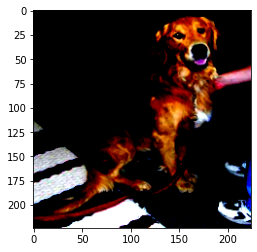

In [11]:
import matplotlib.pyplot as plt

plt.imshow(x.permute(1,2,0))

batch size decides how many of your data items are taken together in a single batch, while you apply the back propagation.

### Hyperparameters

In [12]:
batch_size = 20
learning_rate = 1e-4 #0.001
num_epochs = 1
num_workers = 4
pin_memory =True
checkpoint_file = "checkpoint.tar"
weight_decay = 1e-4


Lets get the dataloader

In [13]:
train_dataloader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size)

# Okay. Now onto the model,

In [14]:
from torchvision.models import resnet18

In [15]:
model = resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [16]:
for param in model.parameters():
    param.requires_grad = False

In [17]:
import torch.nn as nn

In [18]:
model.fc = nn.Linear(in_features=512, out_features=2, bias=True)

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
model = model.to(device=device)

In [21]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
loss_criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)

In [23]:
from tqdm import tqdm

for epoch in range(num_epochs):
    for data, target in tqdm(train_dataloader):
        data = data.to(device=device)
        target = target.to(device=device)
        
        score = model(data)
        
        loss = loss_criterion(score, target)
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
    print(f"For epoch: {epoch} loss: {loss}")
        

100%|██████████| 250/250 [00:24<00:00, 10.32it/s]

For epoch: 0 loss: 0.37587207555770874


In [24]:
def check_accuracy(model, loader):
    model.train()
    
    total_correct = 0
    total_predictions = 0
    
    for x, y in tqdm(loader):
        x = x.to(device=device)
        y = y.to(device=device)
        
        
        score = model(x)
        z, predictions = score.max(1)
        
#         print(f"score shape : {score.shape} , z: {z}, predictions: {predictions}, predictions shape: {predictions.shape}")
        
        total_correct = (y==predictions).sum()
        total_predictions += predictions.shape[0]
    
    print(f"Out of {total_predictions}, total correct: {total_correct} with an accuracy of {float(total_correct/total_predictions)* 100}")

In [25]:
check_accuracy(model, train_dataloader)

100%|██████████| 250/250 [00:23<00:00, 10.73it/s]

Out of 5000, total correct: 18 with an accuracy of 0.3599999938160181


That is bad performance , but at least it was quick, lets work on inference.

# Inference!

In [26]:
import pandas as pd

submission = pd.read_csv('../input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv')
submission.head()

,id,label
0,1,0.5
1,2,0.5
2,3,0.5
3,4,0.5
4,5,0.5


In [27]:
class testDataset(Dataset):
    def __init__(self, rootdir, transform=my_transform, partial_data=None):
        self.rootdir = rootdir
        self.transform = transform
        if partial_data is not None:
            self.images = os.listdir(rootdir)[:partial_data]
        else :
            self.images = os.listdir(rootdir)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        
#         print(os.path.join(self.rootdir,self.images[index]))
        img = Image.open(os.path.join(self.rootdir,self.images[index])).convert("RGB")
        
#         image = np.array(img)
        
        if self.transform:
            img = self.transform(img)
        
#         if "cat" in self.images[index]:
#             label = 0
            
#         elif "dog" in self.images[index]:
#             label = 1
#         else :
#             label = -1
            
        return img

In [28]:
test_dataset = testDataset("./test")

In [29]:
len(submission), test_dataset.__len__()

(12500, 12500)

In [30]:
test_dataloader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

In [31]:


predictions = []
for x in tqdm(test_dataloader):
    x = x.to(device=device)
    
    score = model(x)
    _, prediction = score.max(1)
    
    predictions.append(prediction)
    

100%|██████████| 12500/12500 [02:28<00:00, 84.02it/s]


In [32]:
len(predictions)

12500

In [33]:
submission["label"] = [int(x) for x in predictions]
submission.head()

,id,label
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [34]:
submission.to_csv("my_submission.csv", index=False)